# Genetic Algorihm for UPC&S

## Import packages

In [35]:
from numpy.random import randint
from numpy.random import rand
import pandas as pd

from tqdm import tqdm
pd.set_option('display.max_row', 500)


## Read Data & Assign the variables

In [3]:
# read data
df_sample = pd.read_csv('sample2.csv')

# assign the variables

cost = df_sample[['item', 'T', 'C']].drop_duplicates().dropna(axis=0)
demand = df_sample[['item', 'T', 'D']].drop_duplicates().dropna(axis=0)
prepaid = df_sample[['item', 'T', 'P']].drop_duplicates().dropna(axis=0)
cycle = df_sample[['item', 'J', 'T', 'M']].drop_duplicates().dropna(axis=0)

cost1 = cost.dropna(axis=0)
demand1 = demand.dropna(axis=0)
prepaid1 = prepaid.dropna(axis=0)
cycle1 = cycle.dropna(axis=0)


ijt_df = pd.DataFrame(df_sample[['item', 'J', 'T']].value_counts()).reset_index()[['item', 'J', 'T']]
ijt_df = ijt_df.sort_values(['item']).reset_index(drop=True)
ijt_set = set()
for index, info in ijt_df.iterrows():
    ijt_set.add((info['item'], info['J'], info['T']))
ijt_set

# variables infomation
T = list(set(df_sample['T']))
I = list(set(df_sample['item']))
J = list(set(df_sample['J']))

# Parameters
cit = {}
pit = {}
dit = {}
mijt = {}

# cit - 단가
for index, info in cost.iterrows():
    cit[info['item'], info['T']] = info['C']
# pit - 선급품/일반품
for index, info in prepaid.iterrows():
    pit[info['item'], info['T']] = info['P']
# dit - 생산목표량
for index, info in demand.iterrows():
    dit[info['item'], info['T']] = info['D']
# mijt - cycle time
for index, info in cycle.iterrows():
    mijt[info['item'], info['J'], info['T']] = info['M']

# adding missing values
for i in I:
    for t in T:
        key = (i, t)
        if key not in cit:
            cit[i, t] = 0
for i in I:
    for t in T:
        key = (i, t)
        if key not in pit:
            pit[i, t] = 0
for i in I:
    for t in T:
        key = (i, t)
        if key not in dit:
            dit[i, t] = 0
for i in I:
    for j in J:
        for t in T:
            key = (i, j, t)
            if key not in mijt:
                mijt[i, j, t] = 0

In [79]:
### 실제 데이터로 바꿔야 합니다
df_raw = pd.read_excel('생산미결리스트 등 샘플데이터.xlsx', sheet_name=None)
machine_info = df_raw['CYCLETIME'][1:].reset_index(drop=True)
item_info = df_raw['생산미결리스트(for cost)'].reset_index(drop=True)
# item-단가 unique 하지 않음 (수량이 다르므로) ==> item 별로 합산을 해서 총 수량을 하기엔... 영업납기일이 다름..! 흠..
# 데이터 자체를 쓰기가.. 흠..demand 부터 뽑는것이 애매함
item_info[['중산도면', '수량']].value_counts()
#item_info[item_info['중산도면']=='057386']



# variables infomation
T = list(set(item_info['영업납기']))
I = list(set(item_info['중산도면']))
J = list(set(machine_info['MCNO']))



machine_info[['JSDWG', 'MCNO']].value_counts() # 이건 unique함!

machine_cap = {} # mijt
for index, info in machine_info.iterrows():
    item = info['JSDWG']
    machine = info['MCNO']
    machine_cap[item, machine] = info['AVG_CT']
item_cost = {} # cit
for index, info in item_info.iterrows():
    item = info['중산도면']
    date = info['영업납기']
    item_cost[item, date] = int(info['단가'])
item_demand = {} # dit
for index, info in item_info.iterrows():
    item = info['중산도면']
    date = info['영업납기']
    item_demand[item, date] = int(info['수량'])
item_urgent = {} # pit
for index, info in item_info.iterrows():
    item = info['중산도면']
    date = info['영업납기']
    if info['선급'] != info['선급']:
        item_urgent[item, date] = 1
    else:
        item_urgent[item, date] = 0


mijt = machine_cap
cit = item_cost
dit = item_demand
pit = item_urgent

for i in I:
    for t in T:
        key = (i, t)
        if key not in cit:
            cit[i, t] = 0
for i in I:
    for t in T:
        key = (i, t)
        if key not in pit:
            pit[i, t] = 0
for i in I:
    for t in T:
        key = (i, t)
        if key not in dit:
            dit[i, t] = 0
for i in I:
    for j in J:
        key = (i, j)
        if key not in machine_cap:
            mijt[i, j, t] = 0
        else:
            mijt[i, j, t] = machine_cap[i, j]


In [80]:
mijt

{('050060', '0433'): 1.08,
 ('050093', '0404'): 7.13,
 ('050093', '0408'): 4.67,
 ('050093', '0410'): 4.5,
 ('050093', '0416'): 3.92,
 ('050093', '0417'): 4.17,
 ('050093', '0424'): 4.2,
 ('050093', '0433'): 4.15,
 ('050095', '0433'): 4.68,
 ('050095', '0434'): 1.51,
 ('050105', '0426'): 2,
 ('050110', '0427'): 2,
 ('050110', '0435'): 1.82,
 ('050110', '0436'): 2.02,
 ('050153', '0407'): 5.46,
 ('050153', '0408'): 4.43,
 ('050153', '0409'): 5.12,
 ('050153', '0410'): 1.11,
 ('050153', '0416'): 4.5,
 ('050153', '0424'): 3.7,
 ('050153', '0425'): 4.52,
 ('050153', '0426'): 3.33,
 ('050153', '0433'): 1.46,
 ('050153', '0434'): 1.25,
 ('050153', '0435'): 2.33,
 ('050153', '0436'): 3.6,
 ('050153', '0438'): 1.32,
 ('050153', '0439'): 4.49,
 ('050153', '0440'): 4.47,
 ('050173', '0433'): 9,
 ('050173', '0435'): 10.52,
 ('050178', '0408'): 3.7,
 ('050178', '0416'): 3.6,
 ('050178', '0424'): 4.5,
 ('050178', '0425'): 2.8,
 ('050178', '0433'): 3.83,
 ('050178', '0435'): 3.42,
 ('050181', '0404'

## Genetic Alogorithm

In [82]:
def dict2bitstring(xijt):
    return list(xijt.values())


def bitstring2dict(bitstring, type='xijt'):
    if type == 'xijt':
        _keys = xijt_keys
    elif type == 'mijt':
        _keys = mijt_keys

    for idx, value in enumerate(bitstring):
        xijt[_keys[idx]] = value
    return xijt


def generation_xijt():
    xijt = {}
    for i in I:
        for j in J:
            for t in T:
                if dit[i, t] > 0:
                    xijt[i, j, t] = randint(0, dit[i, t]) # 300, 바뀌어야 함
                else:
                    xijt[i, j, t] = 0
    return xijt


def decode(mijt, xijt):
    for j in J:
        for t in T:
            for i in I:
                if mijt[i, j, t] == 0:
                    xijt[i, j, t] = 0

    for i in I:
        for j in J:
            for t in T:
                if xijt[i, j, t] < 0:
                    xijt[i, j, t] = 0
    return xijt


def constraint_check(xijt):
    #  Constraint 2
    for j in J:
        for t in T:
            check_value = sum(mijt[i, j, t]*xijt[i, j, t] for i in I) <=  600
            if check_value == False:
                for i in I:
                    xijt[i, j, t] = 0

    return xijt


def objective(xijt):
    uit = {}
    xijt = constraint_check(xijt)
    for i in I:
        for t in T:
            u = dit[i, t] - sum(xijt[i, j, t] for j in J)
            if u >= 0:
                uit[i, t] = u
            else:
                uit[i, t] = abs(u)*1000
    objective = sum(uit[i, t]*cit[i, t]*pit[i, t] for i in I for t in T)
    return objective


# tournament selection
def selection(pop, scores, k=5):
    # first random selection
    selection_ix = randint(len(pop))
    for ix in randint(0, len(pop), k-1):
        # check if better (e.g. perform a tournament)
        if scores[ix] < scores[selection_ix]:
            selection_ix = ix
    return pop[selection_ix]


def crossover(p1, p2, r_cross):
    p1 = dict2bitstring(p1)
    p2 = dict2bitstring(p2)
    # children are copies of parents by default
    c1, c2 = p1.copy(), p2.copy()
    # check for recombination
    if rand() < r_cross:
        # select crossover point that is not on the end of the string
        pt = randint(1, len(p1)-2)
        # perform crossover
        c1 = p1[:pt] + p2[pt:]
        c2 = p2[:pt] + p1[pt:]

    return [c1, c2]


# mutation operator
def mutation(bitstring, r_mut):
    for i in range(len(bitstring)):
        # check for a mutation
        if rand() < r_mut:
            # flip the bit
            bitstring[i] = 1 - bitstring[i]


def genetic_algorithm(objective, bounds, n_iter, n_pop, r_cross, r_mut):
    log = []
    pop = [generation_xijt() for _ in range(n_pop)]
    best, best_eval = decode(mijt, pop[0]), objective(decode(mijt, pop[0]))
    print(best_eval)

    for gen in tqdm(range(n_iter)):
        decoded = [decode(mijt, p) for p in pop]
        # evaluate all candidates in the population
        scores = [objective(d) for d in decoded]

        # check for new best solution
        for i in range(n_pop):
            if scores[i] < best_eval:
                best, best_eval = pop[i], scores[i]
                print(f'>best! {gen}, {scores[i]}')
                
        # select parents
        selected = [selection(pop, scores) for _ in range(n_pop)]

        children = list()
        for i in range(0, n_pop, 2):
            # get selected parents in pairs
            p1, p2 = selected[i], selected[i+1]
            # crossover and mutation
            for c in crossover(p1, p2, r_cross):
                # mutation
                mutation(c, r_mut)
                # store for next generation
                children.append(bitstring2dict(c))
        pop = children
        log.append([gen, best_eval])
    return [best, best_eval, log]


In [84]:
xijt = generation_xijt()

# number of generations
n_iter = 100
# bits per variable
n_bits = 16
# define the population size
n_pop = 10
# crossover rate
r_cross = 0.8
# mutation rate
r_mut = 1.0 / (float(n_bits) * len(xijt))


xijt_keys = list(xijt.keys())
mijt_keys = list(mijt.keys())

best, score, log = genetic_algorithm(objective, mijt, n_iter, n_pop, r_cross, r_mut)
print('Done!')


KeyError: ('063342', nan, Timestamp('2021-05-10 00:00:00'))

<AxesSubplot:>

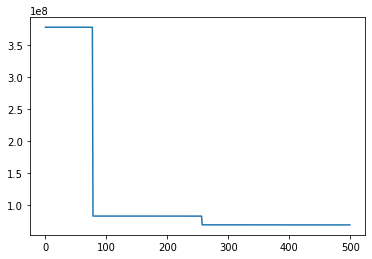

In [59]:
pd.DataFrame(log)[1].plot()

In [ ]:
1377698

50499512
50499512
56092290
57651186
66387156
526497286
66387156

In [60]:
sol = pd.DataFrame.from_dict(best, orient='index')
sol[sol[0]>0]

,0
"(K04033, 422, 1)",1
"(K04033, 409, 1)",1
"(K04033, 409, 3)",1
"(K04046, 409, 2)",15
"(K57386, 404, 6)",1
"(K57386, 409, 6)",1
"(K04031, 426, 1)",1
"(K04031, 409, 1)",1
"(K04031, 409, 4)",1
"(K62716, 416, 4)",1
